# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import nltk
from nltk.corpus import stopwords
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('maxent_ne_chunker')
nltk.download('words')

import re
import time
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import sqlalchemy as db

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import pickle

import random
random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# params for the visualizations
params_visualizations = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

In [3]:
# load data from database
engine = db.create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages', engine)
X = df[['message', 'genre', 'len']]
Y = df.drop(columns = ['id', 'message', 'original', 'genre', 'len', 'lang']).values

In [4]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report', 'lang', 'len'],
      dtype='object')

In [5]:
labels = df.columns[4:-2]

In [6]:
df.columns[4:-2]

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

### 2. Write a tokenization function to process your text data

In [7]:
# pattern to detect url's.
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
hashtag_regex = '#[A-Za-z0-9]*'
user_regex = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)'

def tokenize(text):
    # change urls by the word "urlplaceholder"
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    detected_users = re.findall(user_regex, text)
    for users in detected_users:
        text = text.replace(users, "userplaceholder")
    
    
    # replace all the chars not in a-z, A-Z or 0-9 by " "
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # tokenize the text and drop the the stop words in Enghish
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    # initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize each token and return a list of lower lematized tokens
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


In [8]:
# print the full text in a row
pd.set_option('display.max_colwidth', -1)

In [9]:
# print the five first rows in X.
X[:5].message.values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name',
       'UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.',
       'says: west side of Haiti, rest of the country today and tonight'],
      dtype=object)

In [10]:
# we apply the function above to the  first five rows
for text in X[:5].message.values:
    tokens = tokenize(text)
    print(tokens, '\n')

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti'] 

['is', 'hurricane'] 

['looking', 'someone', 'name'] 

['un', 'report', 'leogane', '80', '90', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supply', 'desperately'] 

['say', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight'] 



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

The first model we are going to try it will be the Random Forest Classifier:

In [11]:
# we define a simply machine learning pipeline with three steps:
#     -Vectorize the tokens obtained with the function tokenize
#     -Apply a TFIDF transformation
#     -Use a Random Fores Model to do the classifications
pipeline_random_forest = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=35)))
    ])

In [12]:
# these are the params of this pipeline
pipeline_random_forest.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x00000200908D31F8>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('multi_clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          ma

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
# Split the data in two groups for training and testing
X_train_1, X_test_1, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
X_train = X_train_1.message.values

In [15]:
X_test = X_test_1.message.values

In [16]:
X_train.shape, Y_train.shape

((20816,), (20816, 35))

In [17]:
X_test.shape, Y_test.shape

((5205,), (5205, 35))

First we are going to define some decorators to print the time taken to fit and evaluate each model.

In [18]:
# we define a function to define a decorator to print the time took in executing a function
def elapsed_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = time.time() - start_time
        print('Elapsed Time: ', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
        return result
    return wrapper

In [19]:
# define a function to fit a model
@elapsed_time_decorator
def model_fit(model, X_train, Y_train):
    model.fit(X_train, Y_train)

# define a function make predictions
@elapsed_time_decorator
def model_predict(model, X_test):
    Y_pred = model.predict(X_test)
    return Y_pred
    
# define a function to fit a model and make the predictions
@elapsed_time_decorator
def model_fit_pred(model, X_train, X_test, Y_train):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return Y_pred

   

In [20]:
# fit the model defined in pipeline_random_forest
model_fit(pipeline_random_forest, X_train, Y_train)

Elapsed Time:  00:07:52


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

We have defined also a function to display the results for all the labels in a printout or returning a dataframe with all the information of precision, recall etc.

In [21]:
def display_results(y_test, y_pred, labels, printout = False):
    '''
    USAGE: 
        It prints the resulst of sklearn.metrics.classification_report.
        
    INPUT
        y_test: Lists with the real values for the response variables
        y_pred: Lists with the predicted values for the response variables.
        labels: Names or labels for the response variables
        printout: False: returns a dataframe with the sesult values for each label
                  True: returns a printout.
    OUTPUT
        result: A dataframe with the values of precision, reacall, f1-score, support,
                accuracy for each label and value (0 or 1)
    '''
    
    i= 0
    
    if printout == False:
        data = []
        result = pd.DataFrame(columns = ['label', 'value', 'precision', 'recall', 'f1-score', 'support', 'accuracy'])
        for label in labels:
        
            class_report = classification_report(y_test[:,i], y_pred[:,i], output_dict = True)
            
            data = [label , 0, 
                    class_report['0']['precision'], 
                    class_report['0']['recall'],
                    class_report['0']['f1-score'],
                    class_report['0']['support'], 
                    class_report['accuracy']]

            s = pd.Series(data, index=result.columns)
            result = result.append(s, ignore_index=True)
            data = [label , 1, 
                    class_report['1']['precision'], 
                    class_report['1']['recall'],
                    class_report['1']['f1-score'],
                    class_report['1']['support'], 
                    class_report['accuracy']]

            s = pd.Series(data, index=result.columns)
            result = result.append(s, ignore_index=True)
            i += 1
        return result
        
    else:
        for label in labels:
            class_report = classification_report(y_test[:,i], y_pred[:,i])
            accuracy = (y_pred[:,i] == y_test[:,i]).mean()
            print("Label: ", label)
            print("Confusion Matrix:\n", class_report)
            print("Accuracy:", accuracy)
            i += 1
        
        
    

In [22]:
pipeline_random_forest

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [23]:
# make a prediction of the outputs
Y_pred = model_predict(pipeline_random_forest, X_test)

Elapsed Time:  00:01:05


In [24]:
# we save the results for random forest into the variable results_random_forest
results_random_forest = display_results(Y_test, Y_pred, labels)

C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# these are the values of precision, recall, etc when the value is equal to 1
results_random_forest[results_random_forest.value == 1].sort_values(by = 'f1-score', ascending=False)

,label,value,precision,recall,f1-score,support,accuracy
1,related,1,0.848955,0.944014,0.893964,4001,0.827858
63,earthquake,1,0.914027,0.784466,0.844305,515,0.971374
55,weather_related,1,0.851822,0.710811,0.774954,1480,0.882613
7,aid_related,1,0.750125,0.692131,0.719962,2173,0.775216
21,food,1,0.833333,0.562284,0.671488,578,0.938905
57,floods,1,0.927966,0.487751,0.639416,449,0.952546
59,storm,1,0.762918,0.526205,0.622829,477,0.941595
3,request,1,0.805915,0.492655,0.611501,885,0.893564
23,shelter,1,0.842795,0.423246,0.563504,456,0.942555
69,direct_report,1,0.789357,0.358149,0.492734,994,0.859174


We are going to plot some histograms to analyze these results.

First, we will see distribution of the precision and recall when a message is labeled as zero for each category.

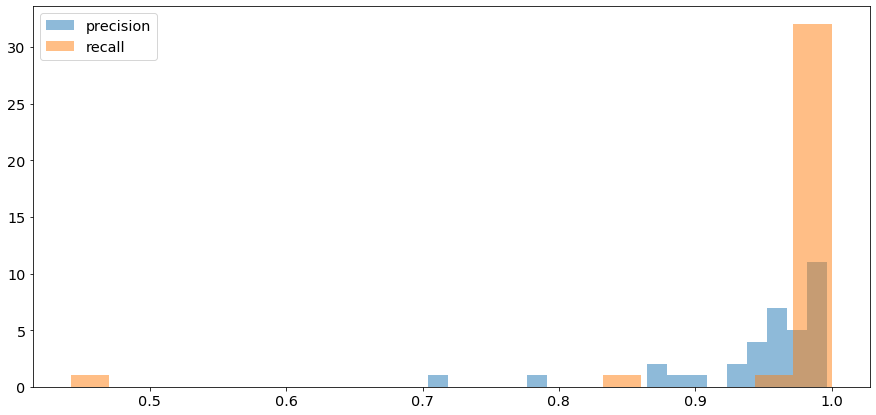

In [26]:
plt.rcParams.update(params_visualizations)
plt.hist(results_random_forest[results_random_forest.value == 0]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_random_forest[results_random_forest.value == 0]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')

plt.show()

In this case the results are quite good. Normally we have a lot more cases with value zero than one for each label. So it is normal to have good results in this case.

Let's see what happens when the messages are labeled with a one. 

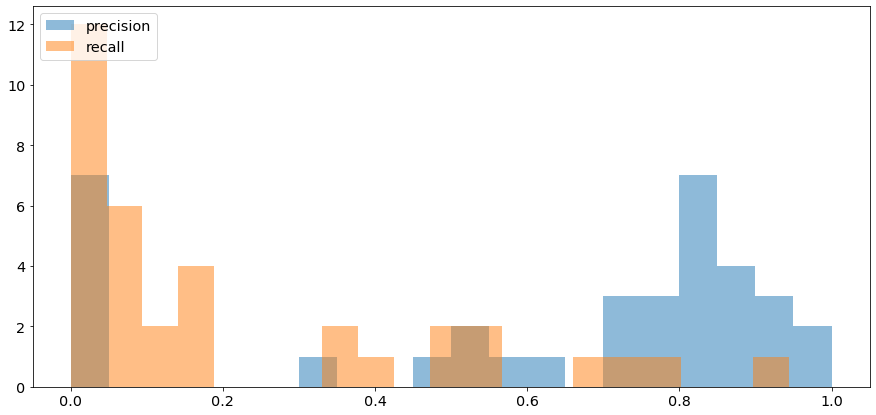

In [27]:
plt.hist(results_random_forest[results_random_forest.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_random_forest[results_random_forest.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')

plt.show()

In this case we can see that the precision, in blue, is quite good. That means that a message that has been assigned to a category has a relatively high probability of having been correctly labeled. But the recalls are not so high, which means that there a lot of messages that belong to each category that are not labeled inside them. We miss a lot of true positives, but we don't have so many false positives.

Now we are going to draw the results for the f1-score. This value takes into consideration the results for precision and recall. We depict in blue the f1-score when the labels have the value 0 for a message, and in orange when the labels have the value 1. 

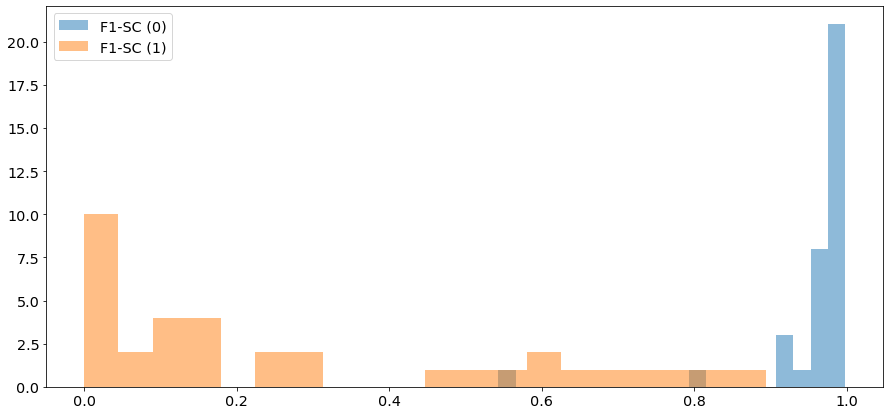

In [28]:
plt.hist(results_random_forest[results_random_forest.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_random_forest[results_random_forest.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left')

plt.show()

As we saw in the two pictures before the predictions are a lot more accurate when the value of a labes is 0 than when the value is 1, we have a lot more messages labeled as 0 than as 1 in each caqtegory, then this is normal.

### 6. Trying other models

Following the advice given in this exercise we are going to try other algorithms of machine learning. For example we could make the classification using K-Neighbors.

In [29]:
# define a pipeline for k-neighbors
pipeline_kneigh = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
    ])

In [30]:
# fit and predict with the model defined in pipeline_kneigh
Y_pred = model_fit_pred(pipeline_kneigh, X_train, X_test, Y_train)

results_kneigh = display_results(Y_test, Y_pred, labels)

Elapsed Time:  00:07:21


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
results_kneigh[results_kneigh.value == 1].sort_values(by = 'f1-score', ascending=False)

,label,value,precision,recall,f1-score,support,accuracy
1,related,1,0.860674,0.887778,0.874016,4001,0.803266
63,earthquake,1,0.915385,0.462136,0.614194,515,0.942555
7,aid_related,1,0.731444,0.498850,0.593160,2173,0.714313
3,request,1,0.720690,0.472316,0.570648,885,0.879155
55,weather_related,1,0.791063,0.442568,0.567591,1480,0.808261
69,direct_report,1,0.700413,0.341046,0.458728,994,0.846302
21,food,1,0.793722,0.306228,0.441948,578,0.914121
59,storm,1,0.698324,0.262055,0.381098,477,0.921998
19,water,1,0.845238,0.205797,0.331002,345,0.944861
23,shelter,1,0.769231,0.175439,0.285714,456,0.923151


We can also try to make predictions using Naive Bayes:

In [32]:
# define a pipeline for Naive Bayes
pipeline_naive_bayes = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
    ])

In [33]:
# fit and predict with the model defined in pipeline_naive_bayes
Y_pred = model_fit_pred(pipeline_naive_bayes, X_train, X_test, Y_train)

results_naive_bayes = display_results(Y_test, Y_pred, labels)


Elapsed Time:  00:04:46


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
results_naive_bayes[results_naive_bayes.value == 1].sort_values(by = 'f1-score', ascending=False)

,label,value,precision,recall,f1-score,support,accuracy
1,related,1,0.787639,0.993752,0.878771,4001,0.789241
7,aid_related,1,0.741988,0.628624,0.680618,2173,0.753698
55,weather_related,1,0.858117,0.425000,0.568459,1480,0.816523
3,request,1,0.843750,0.244068,0.378615,885,0.863785
69,direct_report,1,0.801802,0.179074,0.292763,994,0.834774
63,earthquake,1,0.940299,0.122330,0.216495,515,0.912392
21,food,1,0.850000,0.029412,0.056856,578,0.891643
59,storm,1,0.600000,0.018868,0.036585,477,0.908934
57,floods,1,1.000000,0.002227,0.004444,449,0.913929
11,medical_products,1,0.000000,0.000000,0.000000,254,0.951201


We can also try a SGD Classifier:

In [35]:
# define an pipeline with an SGD Classifier
pipeline_sgd = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(SGDClassifier()))
    ])

In [36]:
# fit and predict with the model defined in pipeline_svc
Y_pred = model_fit_pred(pipeline_sgd, X_train, X_test, Y_train)

results_sgd = display_results(Y_test, Y_pred, labels)

Elapsed Time:  00:05:37


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
results_sgd[results_sgd.value == 1].sort_values(by = 'f1-score', ascending=False)

,label,value,precision,recall,f1-score,support,accuracy
1,related,1,0.847262,0.955261,0.898026,4001,0.833237
63,earthquake,1,0.908889,0.794175,0.847668,515,0.971758
21,food,1,0.824762,0.749135,0.785131,578,0.954467
55,weather_related,1,0.866444,0.701351,0.775205,1480,0.884342
7,aid_related,1,0.772362,0.663599,0.713861,2173,0.777906
19,water,1,0.814961,0.600000,0.691152,345,0.964457
57,floods,1,0.935484,0.516704,0.665710,449,0.955235
59,storm,1,0.756032,0.591195,0.663529,477,0.945053
3,request,1,0.790620,0.533333,0.636977,885,0.896638
23,shelter,1,0.855513,0.493421,0.625869,456,0.948319


We are going to calculate also the results for the Linear Support Vector Classification Method.

In [38]:
# define a LinearSVC pipeline
pipeline_svc = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(LinearSVC()))
    ])


In [39]:
# fit and predict with the model defined in pipeline_svc
Y_pred = model_fit_pred(pipeline_svc, X_train, X_test, Y_train)

results_svc = display_results(Y_test, Y_pred, labels)


Elapsed Time:  00:05:03


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
results_svc[results_svc.value == 1].sort_values(by = 'f1-score', ascending=False)

,label,value,precision,recall,f1-score,support,accuracy
1,related,1,0.868515,0.908023,0.887830,4001,0.823631
63,earthquake,1,0.893365,0.732039,0.804696,515,0.964841
55,weather_related,1,0.818324,0.706081,0.758070,1480,0.871854
21,food,1,0.815126,0.671280,0.736243,578,0.946590
7,aid_related,1,0.723800,0.680166,0.701305,2173,0.758117
19,water,1,0.784615,0.591304,0.674380,345,0.962152
57,floods,1,0.863158,0.547884,0.670300,449,0.953506
23,shelter,1,0.775701,0.546053,0.640927,456,0.946398
3,request,1,0.724534,0.570621,0.638432,885,0.890106
59,storm,1,0.707254,0.572327,0.632677,477,0.939097


As we did we Random Forests, we are going to see the distribution of the values for precision, recall and f1-score of the different methods to compare them.

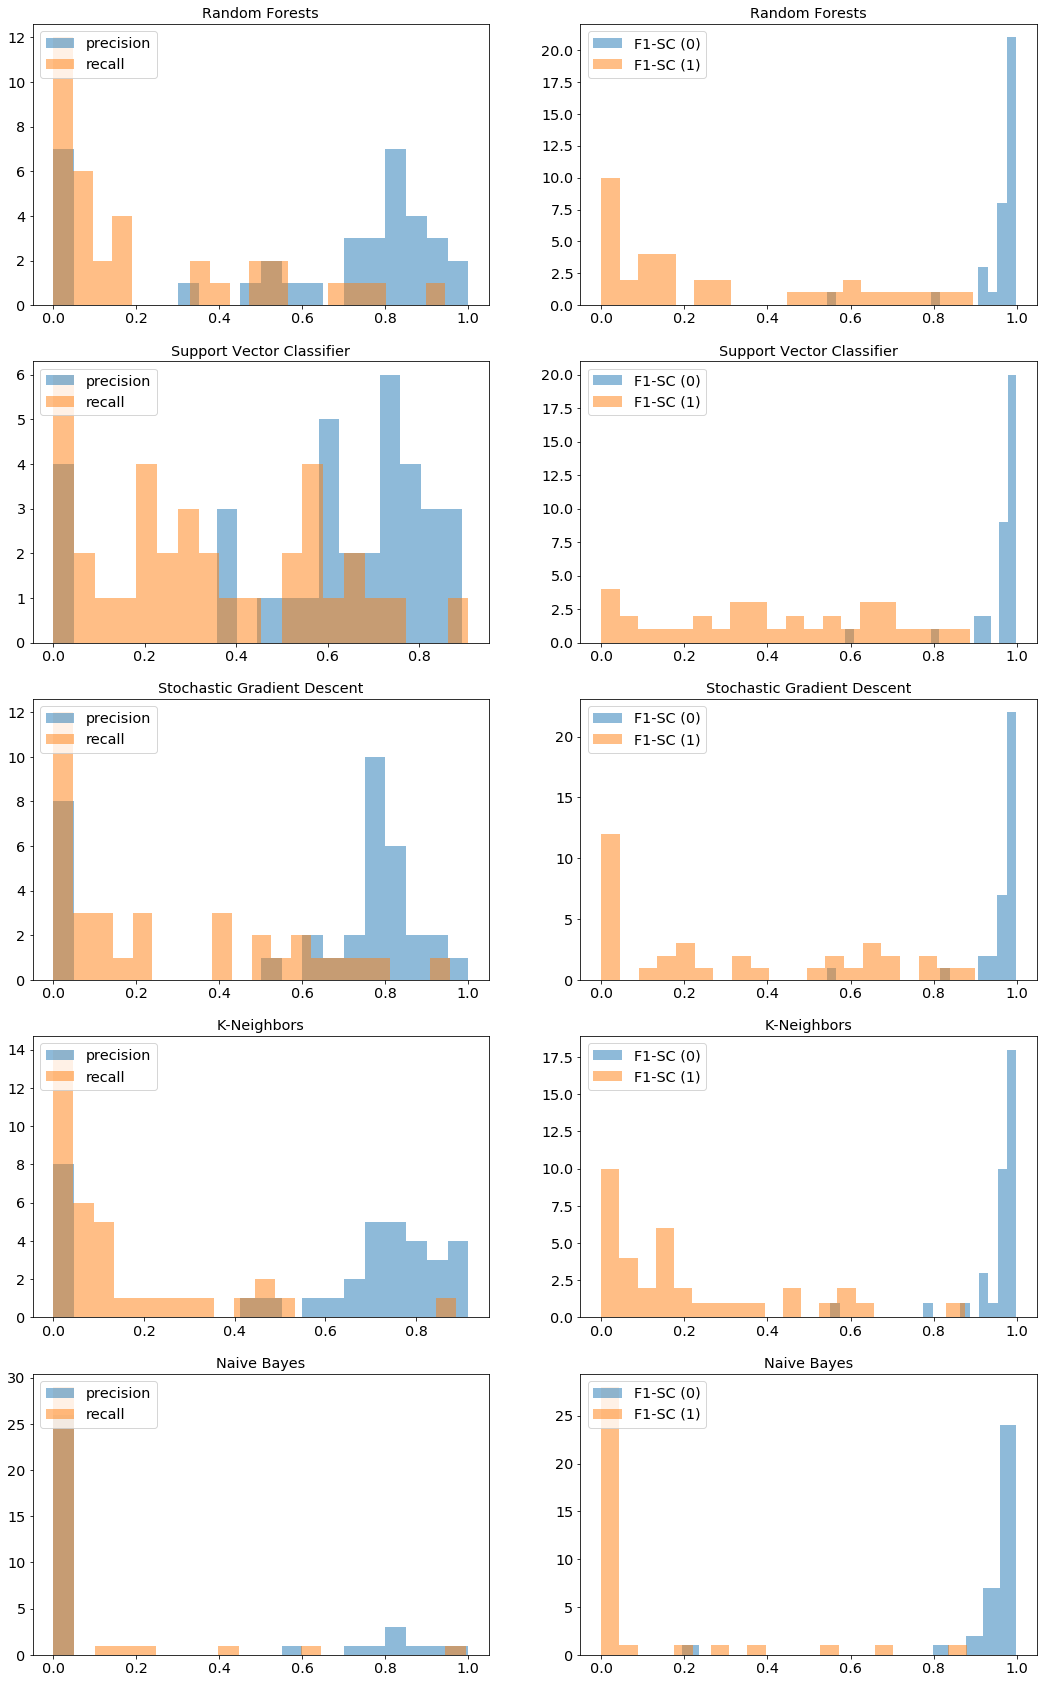

In [42]:
plt.subplots(figsize=(18,30))

# plots for precision and recall of the positives for random forest
plt.subplot(5, 2, 1)
plt.hist(results_random_forest[results_random_forest.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_random_forest[results_random_forest.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forests')

# plots for f1-score of the positives for random forest
plt.subplot(5, 2, 2)
plt.hist(results_random_forest[results_random_forest.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_random_forest[results_random_forest.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forests')

# plots for precision and recall of the positives for svc
plt.subplot(5, 2, 3)
plt.hist(results_svc[results_svc.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_svc[results_svc.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Support Vector Classifier')

# plots for f1-score of the positives for svc
plt.subplot(5, 2, 4)
plt.hist(results_svc[results_svc.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_svc[results_svc.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Support Vector Classifier')

# plots for precision and recall of the positives for sgd
plt.subplot(5, 2, 5)
plt.hist(results_sgd[results_sgd.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_sgd[results_sgd.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Stochastic Gradient Descent')

# plots for f1-score of the positives for sgd
plt.subplot(5, 2, 6)
plt.hist(results_sgd[results_sgd.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_sgd[results_sgd.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Stochastic Gradient Descent')

# plots for precision and recall of the positives for k-neigh
plt.subplot(5, 2, 7)
plt.hist(results_kneigh[results_kneigh.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_kneigh[results_kneigh.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('K-Neighbors')

# plots for f1-score of the positives for k-neigh
plt.subplot(5, 2, 8)
plt.hist(results_kneigh[results_kneigh.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_kneigh[results_kneigh.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('K-Neighbors')

# plots for precision and recall of the positives for naive bayes
plt.subplot(5, 2, 9)
plt.hist(results_naive_bayes[results_naive_bayes.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_naive_bayes[results_naive_bayes.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Naive Bayes')

# plots for f1-score of the positives for naive bayes
plt.subplot(5, 2, 10)
plt.hist(results_naive_bayes[results_naive_bayes.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_naive_bayes[results_naive_bayes.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('Naive Bayes');

In these distributions  we can see that  **the precision can be better for Random Forest, but if we consider both, precision and the recall values, SVC could be the best choice.** Anyway, there is not a big difference between these two models.

Also, in terms of f1-score, SVC can be the best option due to its better behaviour in the recall values.

### 7. Improve your model using GridSearch
Use grid search to find better parameters. 

We are going to apply GridSearch with the intention of optimize some hyperparameters of the model. In the first place we are going to apply GridSearch to the Random Forest Model and to SVC Model because they seems to be the models with a better bahavior.

I would like to test with more hyperparameters, but my laptop is not the most apropriate for this kind of works. With more time or a better laptop I would have tried with more values in the grid.

We are going to apply Grid Search to `Random Forest` and to `SVC` because they have the best performance in the examples above.

Pipeline with `GridSearch` and `RandomForestClassifier`:

In [2]:
**************************************************************************************************
These processes take too long, so I execute the model with the parameters obtained with GridSearch
after then next cell commented like this one
**************************************************************************************************

SyntaxError: invalid syntax (<ipython-input-2-a4a4a1edc68e>, line 1)

In [43]:
# A function to define a grid seach model with random forests
def build_model_rf():
    # define the pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=35)))
    ])
    
    # grid of hyperparameters to test
    parameters = {
        #'vect__ngram_range': ((1, 1), (1, 2)),
        #'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000),
        #'tfidf__use_idf': (True, False),
        #'multi_clf__estimator__n_estimators': [50,200],
        'multi_clf__estimator__min_samples_split': [3, 5]

    }

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid=parameters)
    
    return cv

In [44]:
# define the pipeline pipeline_random_forest_gs
pipeline_random_forest_gs = build_model_rf()

# fit and predict with the model defined in pipeline_random_forest_gs
Y_pred = model_fit_pred(pipeline_random_forest_gs, X_train, X_test, Y_train)

results_rf_gs = display_results(Y_test, Y_pred, labels)

Elapsed Time:  03:17:32


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
pipeline_random_forest_gs.best_params_

{'multi_clf__estimator__min_samples_split': 3, 'vect__max_features': 5000}

It seems that the best results were obtained for `min_samples_split = 3` and `max_features = 5000`.

Pipeline with `GridSearch` and `SVC`:

In [46]:
def build_model_svc():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(LinearSVC()))
    ])

    parameters = {
       # 'vect__ngram_range': ((1, 1), (1, 2)),
       # 'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000),
        'multi_clf__estimator__C':[1,10,100,1000]

        }
    
    cv = GridSearchCV(pipeline, param_grid=parameters)
    
    return cv

In [47]:
# define the pipeline pipeline_svc_gs
pipeline_svc_gs = build_model_svc()

# fit and predict with the model defined in pipeline_svc_gs
Y_pred = model_fit_pred(pipeline_svc_gs, X_train, X_test, Y_train)

results_svc_gs = display_results(Y_test, Y_pred, labels)

C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to c

Elapsed Time:  05:41:19


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
pipeline_svc_gs.best_params_

{'multi_clf__estimator__C': 1, 'vect__max_features': None}

The best results were obtained for `estimator__C = 1` and `max_features = None`.

We are going to draw two bar plots with the values of the f1-score, recall and precision for the two models. We only show the results when the message is labeled as positive (value = 1), since the accuracy when the value = 0 is not a problem.

In these graphs we can compare for each label in the two models:

   * **Precision**: The percentage of the predicted positives that have been correctly assigned.
   
    
   * **Recall**: The percentage of the real positives that have benn correctly assigned.
   
   
   * **f1-score**: The F1 score is the harmonic mean of the precision and recall.
   
   
   
   
   
 ${\displaystyle F_{1}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$

![Precision_Recall](pictures/Precisionrecall.svg.png)
[Image Source: Wikipedia](https://en.wikipedia.org/wiki/F1_score)

In [1]:
**************************************************************************************************
Continue the analysis
**************************************************************************************************

SyntaxError: invalid syntax (<ipython-input-1-f00bb1ca6877>, line 1)

This code is only to not repeat all the training with GridSearch. I execute again the model with the parameters obtained before if I want to generate new objects of the models for doing the rest of the analysis. 

In [80]:
# define a LinearSVC pipeline
pipeline_svc_gs = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, max_features = None)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(LinearSVC(C=1)))
    ])


In [81]:
# fit and predict with the model defined in pipeline_svc
Y_pred = model_fit_pred(pipeline_svc_gs, X_train, X_test, Y_train)

results_svc_gs = display_results(Y_test, Y_pred, labels)


Elapsed Time:  00:06:29


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
# define a Random Forests pipeline
pipeline_rf_gs = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize, max_features = 5000)),
        ('tfidf', TfidfTransformer()),
        ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=35, min_samples_split = 3)))
    ])


In [83]:
# fit and predict with the model defined in pipeline_rf_gs
Y_pred = model_fit_pred(pipeline_rf_gs, X_train, X_test, Y_train)

results_rf_gs = display_results(Y_test, Y_pred, labels)


Elapsed Time:  00:11:47


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


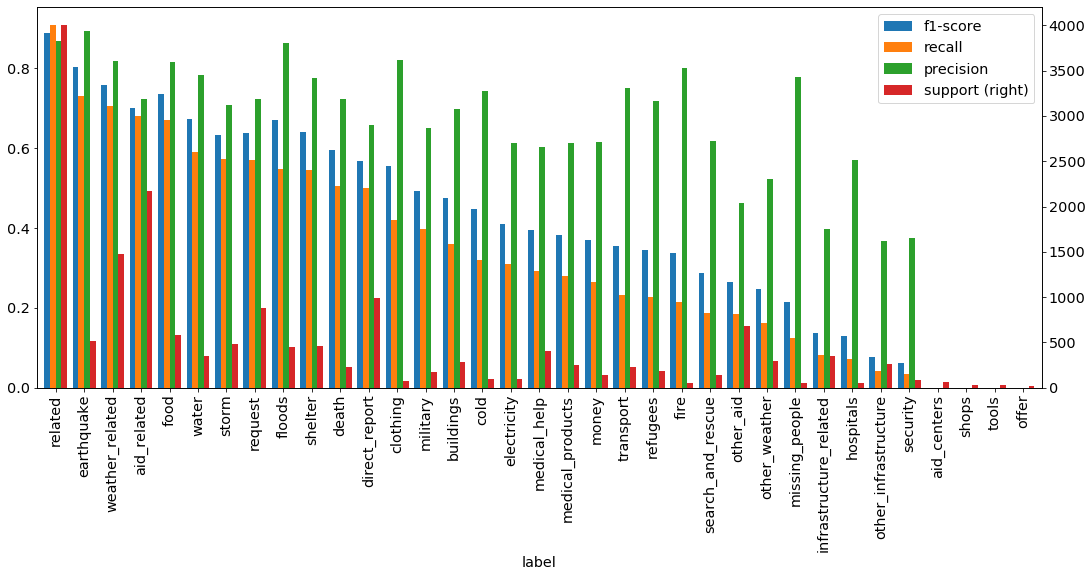

In [84]:

aux_results = results_svc_gs[results_svc_gs.value == 1].sort_values(by = 'recall', 
                                                                  ascending = False)
aux_results = aux_results.set_index('label')
aux_results.plot(kind= 'bar' ,
                 y = ['f1-score', 'recall', 'precision', 'support'],
                 secondary_y = 'support',
                 use_index = True,
                 rot= 90,
                 width = 0.8)
plt.show();

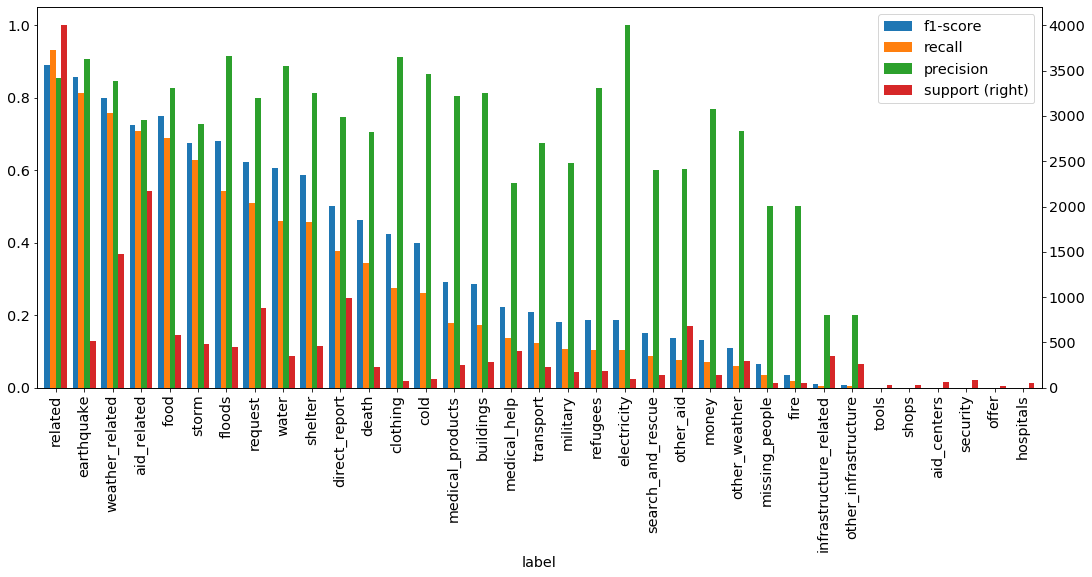

In [85]:

aux_results = results_rf_gs[results_rf_gs.value == 1].sort_values(by = 'recall', 
                                                                  ascending = False)

aux_results = aux_results.set_index('label')

aux_results.plot(kind= 'bar' ,
                 y = ['f1-score', 'recall', 'precision', 'support'],
                 secondary_y = 'support',
                 use_index = True,
                 rot= 90,
                 width = 0.8)
plt.show();

In these two graphs we can see that the precision (green bars) is good in both charts in almost all the labels. 
We can not see a clear improvement in the case of tuning with grid search.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
(We have already tried this before)
* add other features besides the TF-IDF

Following the second piece of adviece of the exercise, we are going to add new features besides the TF-IDF values to try to improve the performance of these two methods: SVC and Random Forest. We are going to use the hyperparameters obtained before. The best option will be to apply GridSearch to the pipeline with the new features, but I think that this is not feasible in my case using my laptop.

To do the new Piupelines this we are going to define some custom transformers to add new features.

In the first transformer we check if the first word is a verb or not.

In [86]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):


    def starting_verb(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = nltk.pos_tag(tokenize(text))

            # index pos_tags to get the first word and part of speech tag
            if len(pos_tags) > 1:
                first_word, first_tag = pos_tags[0]
            
                # return true if the first word is an appropriate verb or RT for retweet
                if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                    return True

            return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In the second transformer we check if the first word is a noun or not.

In [87]:
class StartingNounExtractor(BaseEstimator, TransformerMixin):


    def starting_noun(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = nltk.pos_tag(tokenize(text))

            # index pos_tags to get the first word and part of speech tag
            if len(pos_tags) > 1:
                first_word, first_tag = pos_tags[0]
            
                # return true if the first word is an appropriate verb or RT for retweet
                if first_tag in ['NN', 'NNP']:
                    return True

            return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_noun)
        return pd.DataFrame(X_tagged)

We also going to consider if the text makes refererence to a Geopolitical Entity (GPE).

In [88]:

class GPEExtractor(BaseEstimator, TransformerMixin):

    def gpe_extractor(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            tree = nltk.ne_chunk(nltk.pos_tag(word_tokenize(sentence)))
            if ('GPE' in str(tree)):
                
                return True
            else:
                return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply gpe_extractor function to all values in X
        X_tagged = pd.Series(X).apply(self.gpe_extractor)
        return pd.DataFrame(X_tagged)


In this transformer we search for any refererence to a PERSON.

In [89]:
class PersonExtractor(BaseEstimator, TransformerMixin):

    def person_extractor(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            tree = nltk.ne_chunk(nltk.pos_tag(word_tokenize(sentence)))
            if ('PERSON' in str(tree)):
                return True
            else:
                
                return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply person_extractor function to all values in X
        X_tagged = pd.Series(X).apply(self.person_extractor)
        return pd.DataFrame(X_tagged)

And finally we search for any refererence to an ORGANIZATION.

In [90]:
class OrganizationExtractor(BaseEstimator, TransformerMixin):

    def organization_extractor(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            tree = nltk.ne_chunk(nltk.pos_tag(word_tokenize(sentence)))
            if ('ORGANIZATION' in str(tree)):
                return True
            else:
                return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply organization_extractor function to all values in X
        X_tagged = pd.Series(X).apply(self.organization_extractor)
        return pd.DataFrame(X_tagged)

Now we need to define a pipeline with this new feaures for each ML method.

In [91]:
# define a pipeline for random forest with the features defined above
def model_pipeline_rf_word_type():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            # tfidf fieatues
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize, max_features = 5000)),
                ('tfidf', TfidfTransformer())
                                       ])
             ),
            # features based searching words in the text
             ('person', PersonExtractor()),
             ('organization', OrganizationExtractor()),
             ('gpe', GPEExtractor())

                                   ])
        ),
        ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=35, min_samples_split = 3)))
    ])
    return pipeline

In [92]:
# define a pipeline for svc with the features defined above
def model_pipeline_svc_word_type():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            # tfidf fieatues
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize, max_features = None)),
                ('tfidf', TfidfTransformer())
                                       ])
             ),
            # features based searching words in the text
             ('person', PersonExtractor()),
             ('organization', OrganizationExtractor()),
             ('gpe', GPEExtractor())

                                   ])
        ),
        ('multi_clf', MultiOutputClassifier(LinearSVC(C=1)))
    ])
    return pipeline


We fit the models and we make the predictions to see the accuracy of the results.

In [93]:
# fit and predict with the model defined in model_pipeline_rf_word_type
model_rf_word_type = model_pipeline_rf_word_type()
Y_pred = model_fit_pred(model_rf_word_type, X_train, X_test, Y_train)

results_rf_word_type = display_results(Y_test, Y_pred, labels)


Elapsed Time:  00:33:06


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# fit and predict with the model defined in model_pipeline_rf_word_type
model_svc_word_type = model_pipeline_svc_word_type()
Y_pred = model_fit_pred(model_svc_word_type, X_train, X_test, Y_train)

results_svc_word_type = display_results(Y_test, Y_pred, labels)

Elapsed Time:  00:23:48


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we did before, we are going to plot the distribution of the results for precision, recall and f1-score to compare the different methods.

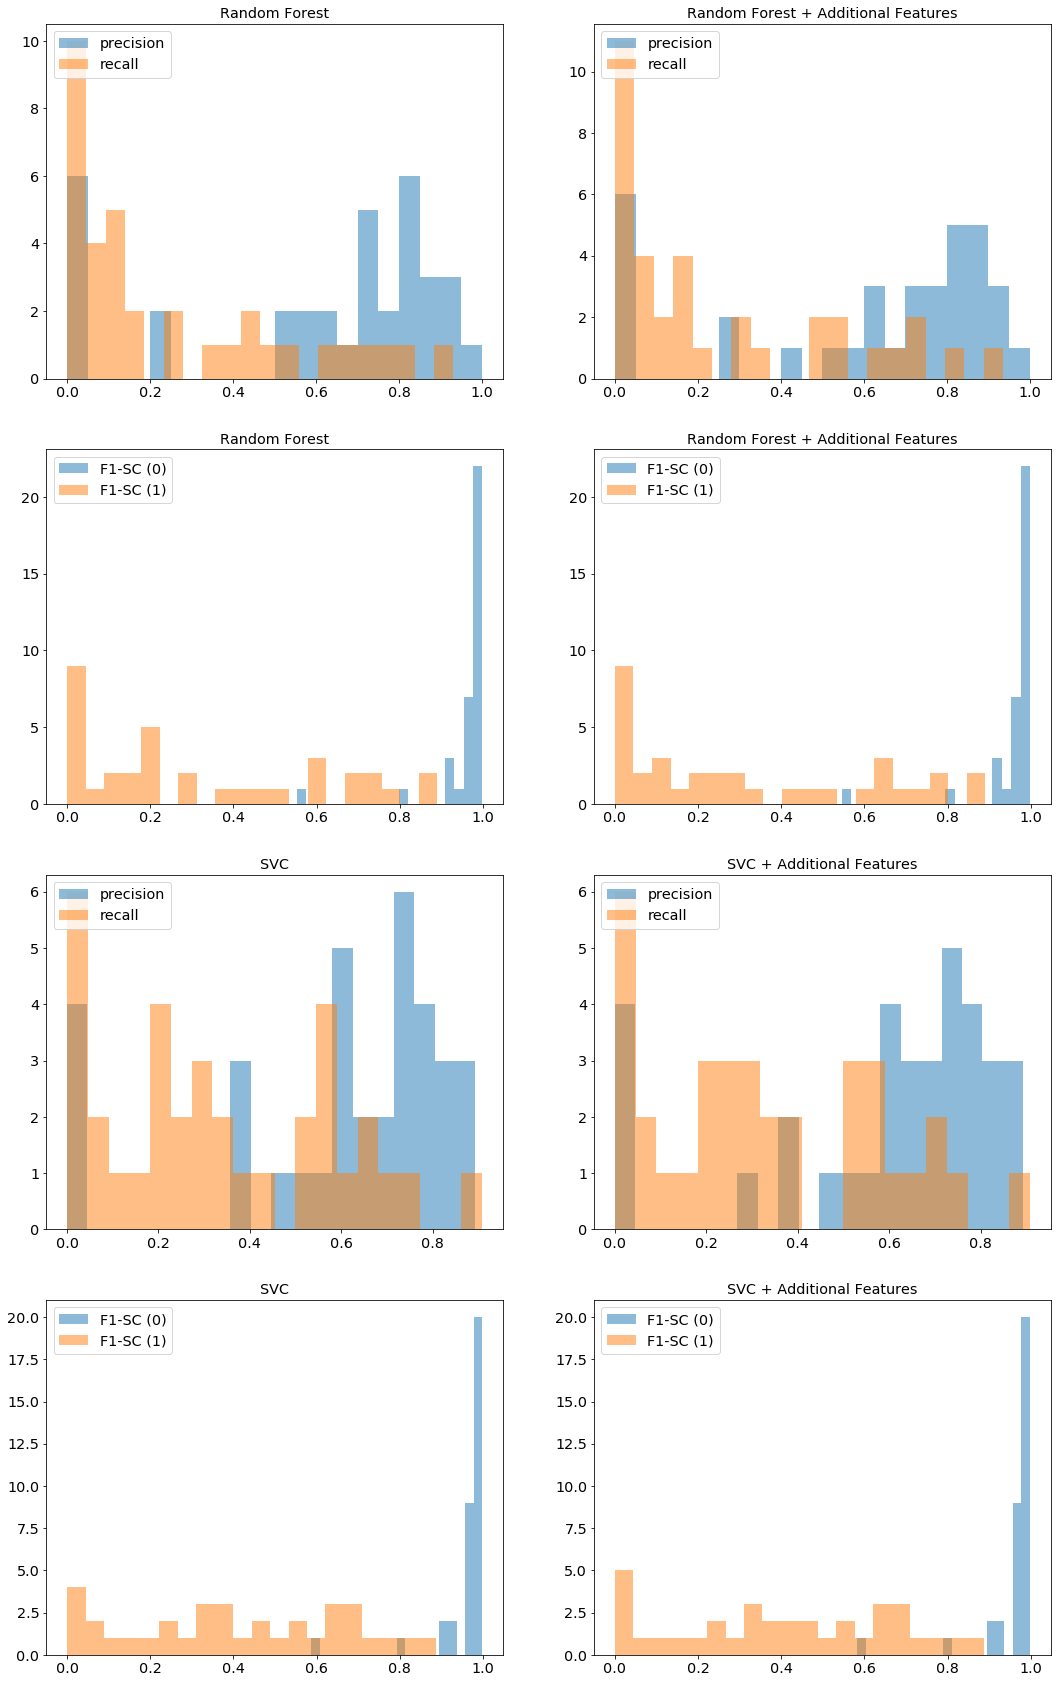

In [95]:
plt.subplots(figsize=(18,30))

# plots for precision and recall of the positives for random_forests without additional features.
plt.subplot(4, 2, 1)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forest')

# plots for precision and recall of the positives for random_forests with additional features.
plt.subplot(4, 2, 2)
plt.hist(results_rf_word_type[results_rf_word_type.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_rf_word_type[results_rf_word_type.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forest + Additional Features')

# plots for f1-score for random_forests without additional features.
plt.subplot(4, 2, 3)
plt.hist(results_rf_gs[results_rf_gs.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('Random Forest')

# plots for f1-score for random_forests with additional features.
plt.subplot(4, 2, 4)
plt.hist(results_rf_word_type[results_rf_word_type.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_rf_word_type[results_rf_word_type.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('Random Forest + Additional Features')

# plots for precision and recall of the positives for svc without additional features.
plt.subplot(4, 2, 5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('SVC')

# plots for precision and recall of the positives for svc with additional features.
plt.subplot(4, 2, 6)
plt.hist(results_svc_word_type[results_svc_word_type.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_svc_word_type[results_svc_word_type.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('SVC + Additional Features')

# plots for f1-score for svc without additional features.
plt.subplot(4, 2, 7)
plt.hist(results_svc_gs[results_svc_gs.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('SVC');

# plots for f1-score for svc with additional features.
plt.subplot(4, 2, 8)
plt.hist(results_svc_word_type[results_svc_word_type.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_svc_word_type[results_svc_word_type.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('SVC + Additional Features');

The features that we have added haven't made a big difference. In the graphs of precision and recall it could be a little better with the new pipelines in both methods, but the improvement is so slightly that it is difficult to appreciate. 

So, we are going to try to add some other features. In the ETL part we add a column with the length of the message, and we have also another column with the genre or origin of the text. We can apply One Hot Encoding to this column and add the result to the list of features to see if we notice some improvement. We are going to apply also StandarScaling to the column with the length of the message.

In [96]:
X.values.shape

(26021, 3)

In [97]:
X.values.reshape(-1,1)

array([['Weather update - a cold front from Cuba that could pass over Haiti'],
       ['direct'],
       [66],
       ...,
       ['A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.'],
       ['news'],
       [209]], dtype=object)

In [98]:
X.values.reshape(-1,1).shape

(78063, 1)

This transforemer converts a Series or a Dataframe into a matrix with two dimensions.
We need this transformer to adapt the result of ColumnSelector before send it to a OneHotEncoder transformation.

In [99]:
# It converts a Series or a Dataframe into a matrix with two dimensions.
class Reshape_Array(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.values.reshape(-1, 1)

This transformer selects the column in which we want to do the tranformation.

In [100]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]



We define the pipelines with all the features extracted till now.

In [101]:
# define a pipeline for random forest with the features:
#     tfidf: ftidf features of the column message.
#     starting_verb: message starts with a verb?
#     starting_noun: message starts with a noum?
#     person: message makes refference to a person?
#     organization: message makes refference to an organization?
#     gpe: message makes refference to a geopolitical entity?
#     len: longitude of the message
#     genre: categorical variable: news, direct or social.

def model_pipeline_rf_complete():
    pipeline = Pipeline([
        ('features', FeatureUnion(
             transformer_list=[
                 # tfidf features over column message
                 ('text_pipeline', Pipeline([
                     ("selector", ColumnSelector(column="message")),
                     ('vect', CountVectorizer(tokenizer=tokenize, max_features = 5000)),
                     ('tfidf', TfidfTransformer())
                     ])
                  ),
                 # search words features over columns message
                  ('word_pipeline', Pipeline([
                        ("selector", ColumnSelector(column="message")),
                         ('word_features', FeatureUnion([
                             ('person', PersonExtractor()),
                             ('organization', OrganizationExtractor()),
                             ('gpe', GPEExtractor())
                             ])
                         )
             
                   ])),
                 # genre features. OneHotEncoding of column genre
                   ('len_pipeline', Pipeline([
                       ('selector', ColumnSelector(column="len")),
                       ('reshape', Reshape_Array()),
                       ('len', StandardScaler())
                       ])
                   ),
                 # genre features. OneHotEncoding of column genre
                   ('genre_pipeline', Pipeline([
                       ('selector', ColumnSelector(column="genre")),
                       ('reshape', Reshape_Array()),
                       ('genre', OneHotEncoder())
                       ])
                   )
            ]
        )),
        # apply Random Forests method
        ('multi_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=35, min_samples_split = 3)))
    ])
    return pipeline

In [102]:
# define a pipeline for svc with the features:
#     tfidf: ftidf features of the column message.
#     starting_verb: message starts with a verb?
#     starting_noun: message starts with a noum?
#     person: message makes refference to a person?
#     organization: message makes refference to an organization?
#     gpe: message makes refference to a geopolitical entity?
#     language: language of original message predicted by langdetect
#     genre: categorical variable: news, direct or social.

def model_pipeline_svc_complete():
    pipeline = Pipeline([
        ('features', FeatureUnion(
             transformer_list=[
                 # tfidf features over column message
                 ('text_pipeline', Pipeline([
                     ("selector", ColumnSelector(column="message")),
                     ('vect', CountVectorizer(tokenizer=tokenize, max_features = None)),
                     ('tfidf', TfidfTransformer())
                     ])
                  ),
                 # search words features over columns message
                  ('word_pipeline', Pipeline([
                         ("selector", ColumnSelector(column="message")),
                         ('word_features', FeatureUnion([
                             ('person', PersonExtractor()),
                             ('organization', OrganizationExtractor()),
                             ('gpe', GPEExtractor())
                             ])
                         )
             
                   ])),
                 # genre features. OneHotEncoding of column genre
                   ('len_pipeline', Pipeline([
                       ('selector', ColumnSelector(column="len")),
                       ('reshape', Reshape_Array()),
                       ('len', StandardScaler())
                       ])
                   ),
                 # genre features. OneHotEncoding of column genre
                   ('genre_pipeline', Pipeline([
                       ('selector', ColumnSelector(column="genre")),
                       ('reshape', Reshape_Array()),
                       ('genre', OneHotEncoder())
                       ])
                   )
            ]
        )),
        # apply LinearSVC method
        ('multi_clf', MultiOutputClassifier(LinearSVC(C=1)))
    ])
    return pipeline


We fit the models and make predictions:

In [103]:
# fit and predict with the model defined in model_pipeline_rf_complete
# in this case we use the dataframes X_train_1 and X_test_1 instead of only the 
# column message. We need to add also the information in the columns genre and lang.
pipeline_rf_complete = model_pipeline_rf_complete()
Y_pred = model_fit_pred(pipeline_rf_complete, X_train_1, X_test_1, Y_train)

results_rf_complete = display_results(Y_test, Y_pred, labels)

Elapsed Time:  00:27:00


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# fit and predict with the model defined in model_pipeline_svc_complete
pipeline_svc_complete = model_pipeline_svc_complete()
Y_pred = model_fit_pred(pipeline_svc_complete, X_train_1, X_test_1, Y_train)

results_svc_complete = display_results(Y_test, Y_pred, labels)

C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Elapsed Time:  00:24:54


C:\Users\jesus\Anaconda3\envs\disaster\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We show the results in plots with the distribution of the variables precision, recall and f1-score as we did with the other models to make comparisons.

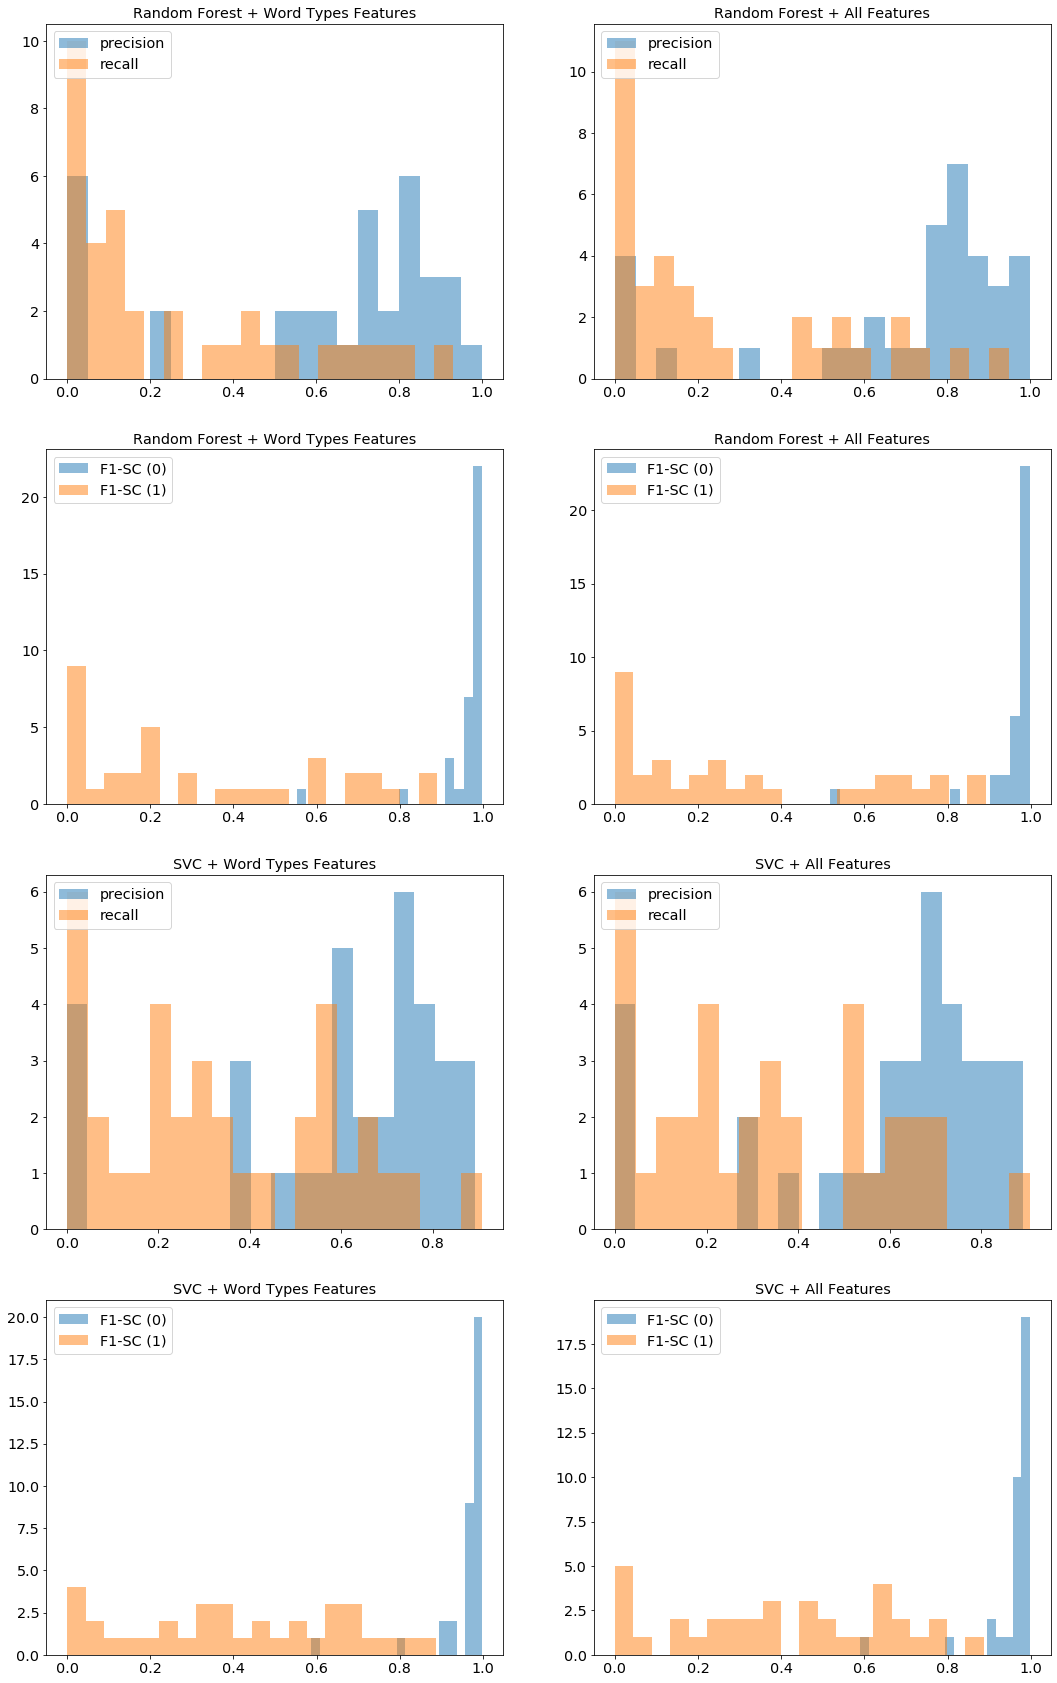

In [105]:
plt.subplots(figsize=(18,30))

# plots for precision and recall of the positives random forests with the fetures based in searchin words in the message
plt.subplot(4, 2, 1)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forest + Word Types Features')

# plots for precision and recall of the positives random forests with all the features (genre and lang inclueded)
plt.subplot(4, 2, 2)
plt.hist(results_rf_complete[results_rf_complete.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_rf_complete[results_rf_complete.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('Random Forest + All Features')

# plots for f1-score in random forests with the fetures based in searchin words in the message
plt.subplot(4, 2, 3)
plt.hist(results_rf_gs[results_rf_gs.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_rf_gs[results_rf_gs.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('Random Forest + Word Types Features')

# plots for f1-score in random forests with all the features (genre and lang inclueded)
plt.subplot(4, 2, 4)
plt.hist(results_rf_complete[results_rf_complete.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_rf_complete[results_rf_complete.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('Random Forest + All Features')

# plots for precision and recall of the positives in SVC with the fetures based in searchin words in the message
plt.subplot(4, 2, 5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('SVC + Word Types Features')

# plots for precision and recall of the positives in SVC with all the features (genre and lang inclueded)
plt.subplot(4, 2, 6)
plt.hist(results_svc_complete[results_svc_complete.value == 1]['precision'], bins = 20, label='precision', alpha = 0.5)
plt.hist(results_svc_complete[results_svc_complete.value == 1]['recall'], bins = 20, label='recall', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('SVC + All Features')

# plots for f1-score in SVC with the fetures based in searchin words in the message
plt.subplot(4, 2, 7)
plt.hist(results_svc_gs[results_svc_gs.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_svc_gs[results_svc_gs.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('SVC + Word Types Features');

# plots for f1-score in SVC with all the features (genre and lang inclueded)
plt.subplot(4, 2, 8)
plt.hist(results_svc_complete[results_svc_complete.value == 0]['f1-score'], bins = 20, label='F1-SC (0)', alpha = 0.5)
plt.hist(results_svc_complete[results_svc_complete.value == 1]['f1-score'], bins = 20, label='F1-SC (1)', alpha = 0.5)
plt.legend(loc='upper left');
plt.title('SVC + All Features');

The improvement in the results continues to be not very obvious.

The histrograms that we have used till now don't permit us to observe the behaviour by label. So we are going to draw the results in bar plots in which we'll be able to see the accuracy for each category in each of the models we have trained so far.

In [106]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

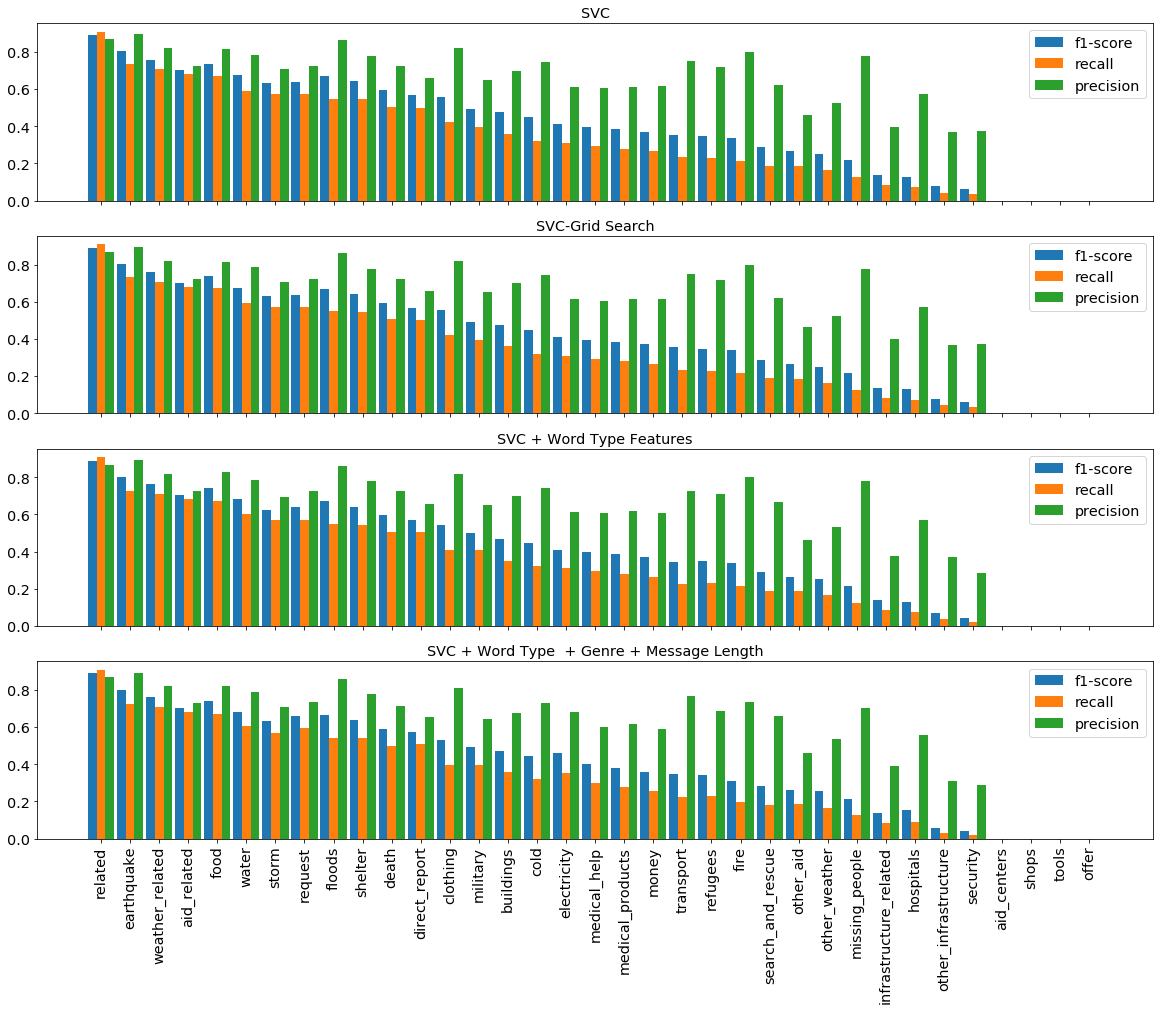

In [107]:

# position of the label in the x-axis
ind = np.arange(len(labels)) 
# width of each bar
width = 0.3

plt.subplots(figsize=(20,15))

# first subplot SVC without additional features
plt.subplot(4, 1, 1)
data1 =results_svc[results_svc.value == 1].sort_values(by = 'recall', ascending = False).reset_index()
# set the label as an ordered categorical variable and use this type and this order in all the bar charts
cat_type = CategoricalDtype(categories=data1.label.values,ordered=True)
data1.label = data1.label.astype(cat_type)
data1 = data1.sort_values('label',ascending=True)

# plot the three values in vertical bars: f1-score, recall and precision
plt.bar( ind , data1['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data1.recall, width, label='recall')
plt.bar( ind + 2*width , data1.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind +  width, " ")
plt.legend(loc="upper right")
plt.title('SVC')

# subplot SVC results with GRID SEARCH
plt.subplot(4, 1, 2)
data2 =results_svc_gs[results_svc_gs.value == 1].sort_values(by = 'recall', ascending = False).reset_index()
# set the column labe as type cat_type defined before. We put the same order in all the charts.
data2.label = data2.label.astype(cat_type)
data2 = data2.sort_values('label',ascending=True)

# plot the three values in vertical bars: f1-score, recall and precision
plt.bar( ind , data2['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data2.recall, width, label='recall')
plt.bar( ind + 2*width , data2.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind +  width, " ")
plt.legend(loc="upper right")
plt.title('SVC-Grid Search')

# second subplot SVC-GS results with tfidf + the features based in seaching types of words
plt.subplot(4, 1, 3)
data3 =results_svc_word_type[results_svc_word_type.value == 1].reset_index()
# set the column labe as type cat_type defined before. We put the same order in all the charts.
data3.label = data3.label.astype(cat_type)
data3 = data3.sort_values('label',ascending=True)
# plots the three values
plt.bar( ind , data3['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data3.recall, width, label='recall')
plt.bar( ind + 2*width , data3.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind + width, " ")
plt.legend(loc="upper right")
plt.title('SVC + Word Type Features')

# third subplot SVC results with tfidf + the features based in seaching types of words +
# the features based in the genre and length of message
plt.subplot(4, 1, 4)
data4 =results_svc_complete[results_svc_complete.value == 1].reset_index()
# set the column labe as type cat_type defined before. We put the same order in all the charts.
data4.label = data4.label.astype(cat_type)
data4 = data4.sort_values('label',ascending=True)
# plots the three values
plt.bar( ind , data4['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data4.recall, width, label='recall')
plt.bar( ind + 2*width , data4.precision, width, label='precision')
plt.xticks(ind + width, data4.label, rotation='vertical')
plt.legend(loc="upper right")
plt.title('SVC + Word Type  + Genre + Message Length');

# merge all the results in a single dataframe to draw a boxplot
# melt the columns 'precision', 'recall', 'f1-score', 'accuracy' in two columns: one with the type
# of measure and other with the value
svc_results = pd.melt(data1.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
# add a column identifying these data as SVC method
svc_results['method'] = 'SVC'

svc_gs_results = pd.melt(data2.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
# add a column identifying these data as SVC method
svc_gs_results['method'] = 'SVC_GS'

# repeat the proccess for the data obtained with the method SVC including word type features
svc_chunk_results = pd.melt(data3.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
svc_chunk_results['method'] = 'SVC_WORD_TYPE'

# repeat the proccess for the data obtained applying the method SVC including all the features
svc_all_results = pd.melt(data4.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
svc_all_results['method'] = 'SVC_ALL_FEATURES'

# concat the three dataframes in a single one
svc_results = svc_results.append(svc_gs_results).append(svc_chunk_results).append(svc_all_results)


We are going to repeat the same proccess as before, but for the Random Forest method

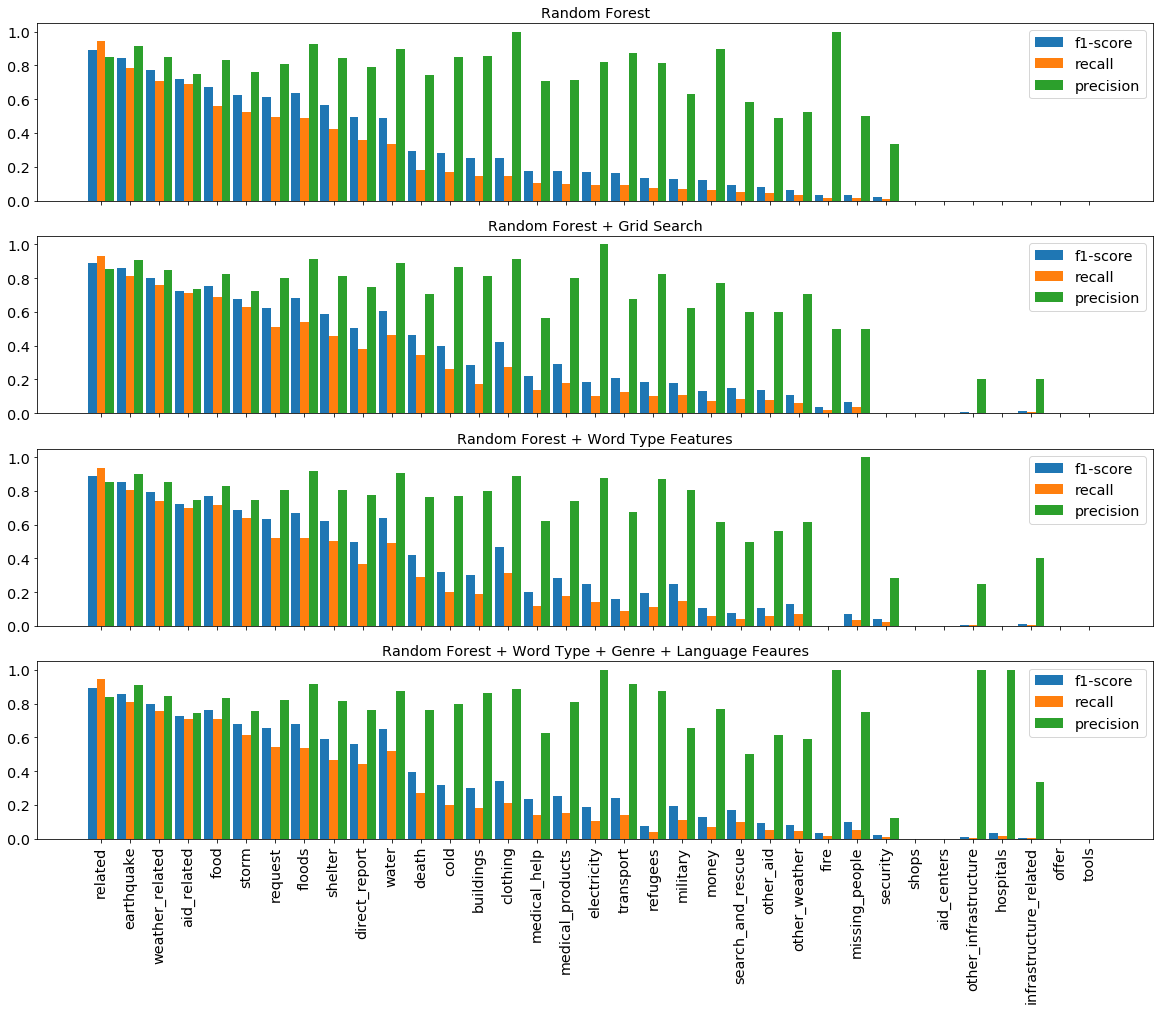

In [108]:

# position of the label in the x-axis
ind = np.arange(len(labels)) 
# width of each bar
width = 0.3

plt.subplots(figsize=(20,15))
# first subplot Random Forests with tfidf
plt.subplot(4, 1, 1)
data1 =results_random_forest[results_random_forest.value == 1].sort_values(by = 'recall', ascending = False).reset_index()
# set the label as an ordered categorical variable and use this type and this order in all the bar charts
cat_type = CategoricalDtype(categories=data1.label.values,ordered=True)
data1.label = data1.label.astype(cat_type)
data1 = data1.sort_values('label',ascending=True)
# plot the three values in vertical bars: f1-score, recall and precision
plt.bar( ind , data1['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data1.recall, width, label='recall')
plt.bar( ind + 2*width , data1.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind +  width, " ")
plt.legend(loc="upper right")
plt.title('Random Forest')


plt.subplot(4, 1, 2)
data2 =results_rf_gs[results_rf_gs.value == 1].sort_values(by = 'recall', ascending = False).reset_index()
# set the label as an ordered categorical variable and use this type and this order in all the bar charts
data2.label = data2.label.astype(cat_type)
data2 = data2.sort_values('label',ascending=True)
# plot the three values in vertical bars: f1-score, recall and precision
plt.bar( ind , data2['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data2.recall, width, label='recall')
plt.bar( ind + 2*width , data2.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind +  width, " ")
plt.legend(loc="upper right")
plt.title('Random Forest + Grid Search')

# second subplot Random Forests results with tfidf + the features based in seaching types of words
plt.subplot(4, 1, 3)
data3 =results_rf_word_type[results_rf_word_type.value == 1].reset_index()
# set the column labe as type cat_type defined before. We put the same order in all the charts.
data3.label = data3.label.astype(cat_type)
data3 = data3.sort_values('label',ascending=True)
# plots the three values
plt.bar( ind , data3['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data3.recall, width, label='recall')
plt.bar( ind + 2*width , data3.precision, width, label='precision')
# remove the xtick labels
plt.xticks(ind + width, " ")
plt.legend(loc="upper right")
plt.title('Random Forest + Word Type Features')

# third subplot SVC results with tfidf + the features based in seaching types of words +
# the features based in the genre and length of message
plt.subplot(4, 1, 4)
data4 =results_rf_complete[results_rf_complete.value == 1].reset_index()
# set the column labe as type cat_type defined before. We put the same order in all the charts.
data4.label = data4.label.astype(cat_type)
data4 = data4.sort_values('label',ascending=True)
# plots the three values
plt.bar( ind , data4['f1-score'], width, label='f1-score')
plt.bar( ind + width  , data4.recall, width, label='recall')
plt.bar( ind + 2*width , data4.precision, width, label='precision')
plt.xticks(ind + width, data4.label, rotation='vertical')
plt.legend(loc="upper right")
plt.title('Random Forest + Word Type + Genre + Language Feaures');

# merge all the results in a single dataframe to draw a boxplot
# melt the columns 'precision', 'recall', 'f1-score', 'accuracy' in two columns: one with the type
# of measure and other with the value
rf_results = pd.melt(data1.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
# add a column identifying these data as RF method
rf_results['method'] = 'RF'

rf_results_gs = pd.melt(data2.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
# add a column identifying these data as RF method
rf_results_gs['method'] = 'RF_GS'

# repeat the proccess for the data obtained with the method Radon Forests including word type features
rf_chunk_results = pd.melt(data3.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
rf_chunk_results['method'] = 'RF_WORD_TYPE'

# repeat the proccess for the data obtained applying the method SVC including all the features
rf_all_results = pd.melt(data4.drop(columns = ['value', 'support']), id_vars=['label'], 
                      value_vars=['precision', 'recall', 'f1-score', 'accuracy'],
                      var_name='Accuracy_Measure', value_name='Value')
rf_all_results['method'] = 'RF_ALL_FEATURES'

# concat the three dataframes in a single one
rf_results = rf_results.append(rf_results_gs).append(rf_chunk_results).append(rf_all_results)


This graphs could help us if we were interested in some particular labels. They are a lot of different catogories, so it is difficult that the predictions are accurate in all the cases. Maybe we could prefer to take a subset of labels in which we expect aceptable results.

In the next graph we draw boxplots for the precision, recall and f1-score in the six principal methods that we have seen.

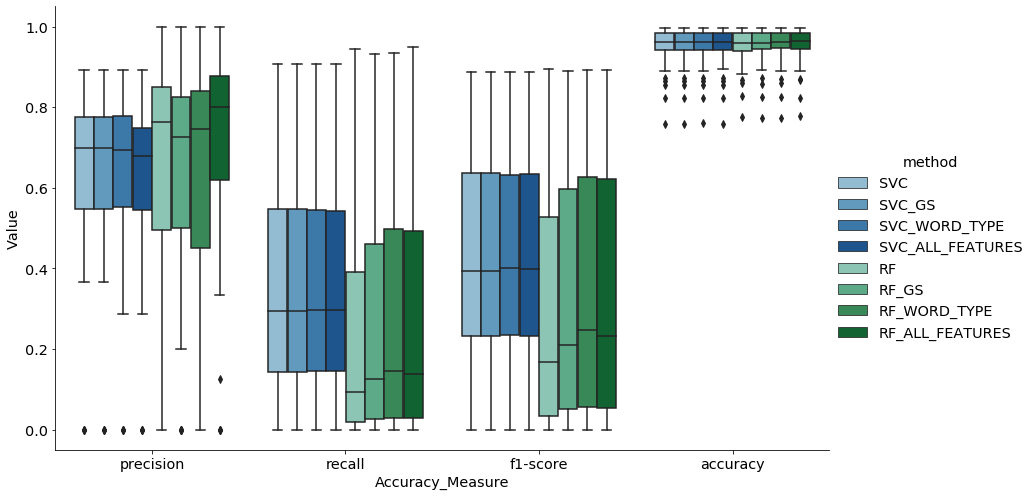

In [109]:
results = svc_results.append(rf_results)
my_pallette = sns.color_palette("Blues")[2:6] + sns.color_palette("BuGn")[2:6]
g = sns.catplot(x="Accuracy_Measure", y="Value",
                hue="method",
                data=results, kind="box",
                palette=my_pallette ,
                height=7, aspect=1.7);

It is more clear that in general Random Forests give us a better precision. This could be the method that we would use if we were interested in not putting a label incorrectly, even if this means to miss a high perectages of messages in each label.

On the other hand, if we want a good balance between the precision and teh recall it is better to choose the SVC method.

All the additional features that we have added to the models seem not to have had any effect. The exception can be the Random Forests method with all features. In this case the value of the precision for all the features have a significativaly higher median. We could think in using the additional features if we were interestee in the highest precision and therefore in random forests.

The Accuracy values are always high, but the problem is that it is calculated taking into account the messages labeled with zero and with one for each category, since most of the messages hava a true value of zero for each category, we would obtain a good accuracy even if we predict that all the message have the value zero. So this value of accuracy is not very meaningful for our purposes.

### 9. Export your model as a pickle file

In [110]:
def save_model(model, model_filepath):
    """ Saving model's best_estimator_ using pickle
    """
    pickle.dump(model, open(model_filepath, 'wb'))
    
save_model(pipeline_random_forest, 'pipeline_random_forest.pkl')
save_model(pipeline_svc, 'pipeline_svc.pkl')
save_model(pipeline_rf_gs, 'pipeline_rf_gs.pkl')
save_model(pipeline_svc_gs, 'pipeline_svc_gs.pkl')
save_model(pipeline_svc_gs, 'pipeline_svc_gs.pkl')
save_model(model_rf_word_type, 'model_rf_word_type.pkl')
save_model(model_svc_word_type, 'model_svc_word_type.pkl')
save_model(pipeline_rf_complete, 'pipeline_rf_complete.pkl')
save_model(pipeline_svc_complete, 'pipeline_svc_complete.pkl')


### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.